# **제조 공정 온도 예측**

데이터 기간: 2017년 12월 ~ 2018년 5월

데이터 형식: csv

데이터 내용: 시간별 GOB온도, 활하부온도

In [ ]:
# 데이터 시각화를 위한 한글 폰트 가져오기

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

**데이터 전처리**

In [ ]:
data = pd.read_csv('/content/제조공정 데이터(GOB온도, 휠하부온도).csv')

In [ ]:
# "24:00"을 "00:00"으로 변환하고 날짜에 하루를 추가하는 과정
data['날짜'] = data['날짜'].str.replace('24:00', '00:00')
data['날짜'] = pd.to_datetime(data['날짜'], format='%m.%d %H:%M')
data.loc[data['날짜'].dt.hour == 0, '날짜'] = data['날짜'] + pd.Timedelta(days=1)

# 연도 조정
data['날짜'] = data['날짜'].apply(lambda x: x.replace(year=2018) if x.month < 6 else x.replace(year=2017))

# 다시 시작과 끝 날짜 확인
start_date_corrected = data['날짜'].min()
end_date_corrected = data['날짜'].max()

start_date_corrected, end_date_corrected

(Timestamp('2017-12-01 04:00:00'), Timestamp('2018-05-31 00:00:00'))

In [ ]:
# 결측치 확인
missing_values = data.isnull().sum()

In [ ]:
# 결측치 결과 및 데이터 타입 확인
missing_values, data.dtypes

(공정 파트        0
 날짜           0
 GOB 온도(℃)    0
 휠 하부온도(℃)    0
 dtype: int64,
 공정 파트                 int64
 날짜           datetime64[ns]
 GOB 온도(℃)             int64
 휠 하부온도(℃)             int64
 dtype: object)

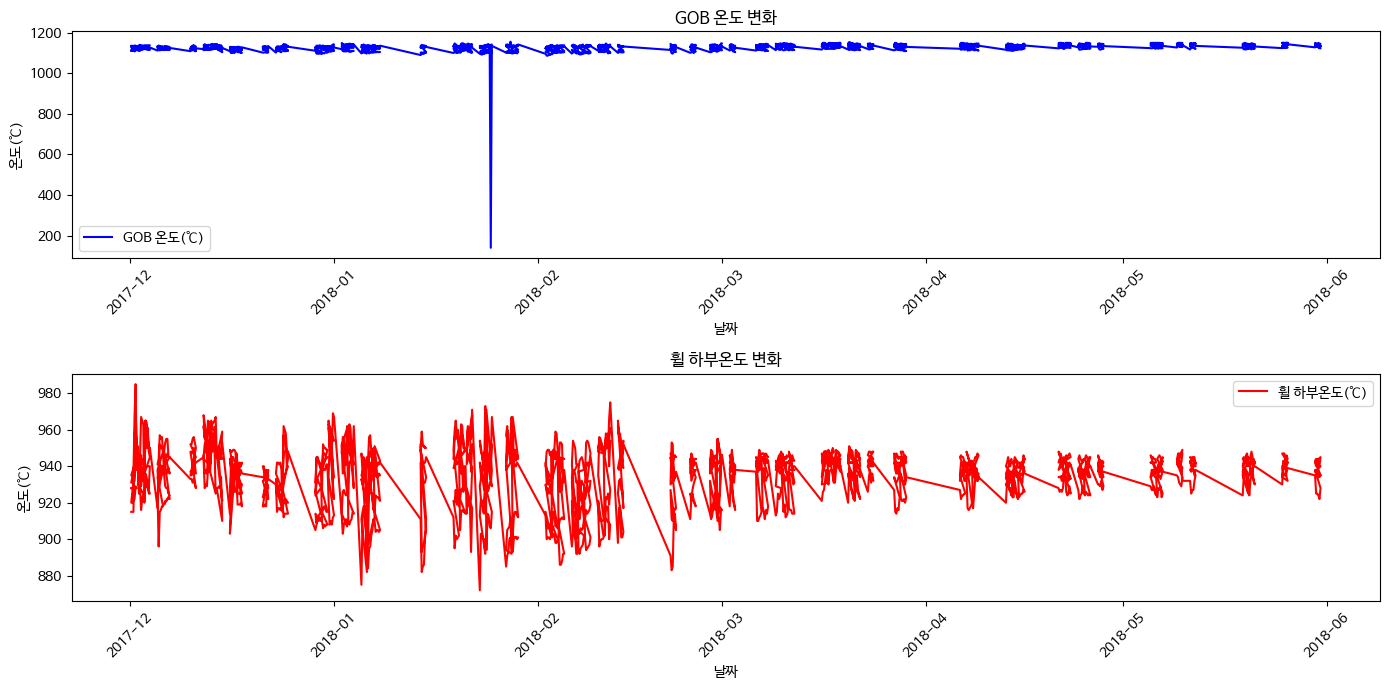

In [ ]:
# Nanum 폰트 지정
plt.rc('font', family='NanumBarunGothic')

# GOB 온도와 휠 하부온도 시각화
plt.figure(figsize=(14, 7))

# GOB 온도
plt.subplot(2, 1, 1)
plt.plot(data['날짜'], data['GOB 온도(℃)'], label='GOB 온도(℃)', color='blue')
plt.title('GOB 온도 변화')
plt.xlabel('날짜')
plt.ylabel('온도(℃)')
plt.legend()
plt.xticks(rotation=45)

# 휠 하부온도
plt.subplot(2, 1, 2)
plt.plot(data['날짜'], data['휠 하부온도(℃)'], label='휠 하부온도(℃)', color='red')
plt.title('휠 하부온도 변화')
plt.xlabel('날짜')
plt.ylabel('온도(℃)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**모델**

`모델 성능 개선 방안`

모델 구조 조정: 더 많은 LSTM 레이어 추가 또는 레이어 별 뉴런(유닛) 수 증가

하이퍼파라미터 조정: 학습률, 배치 크기, 에포크 수 조정

정규화 기법 적용: 과적합 방지를 위한 Dropout 레이어 추가

데이터 증강: 시계열 데이터에서는 어려울 수 있지만, 추가적인 데이터 수집 또는 기존 데이터의 다양화

특성 선택 및 엔지니어링: 더 많은 입력 특성 추가 또는 불필요한 특성 제거

In [ ]:
# 정규화를 위한 MinMaxScaler 초기화
scaler = MinMaxScaler(feature_range=(0, 1))

# GOB 온도와 휠 하부온도를 정규화
scaled_data = scaler.fit_transform(data[['GOB 온도(℃)', '휠 하부온도(℃)']])

# 시퀀스 데이터 생성 함수 정의
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # 입력 시퀀스와 예측 목표를 추출
        X.append(data[i:i+n_steps, :])
        y.append(data[i+n_steps, :])
    return np.array(X), np.array(y)

# 시퀀스 길이 정의
n_steps = 3

# 시퀀스 데이터 생성
X, y = create_sequences(scaled_data, n_steps)

X.shape, y.shape

((2277, 3, 2), (2277, 2))

In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# 시퀀스 길이와 입력 데이터의 형태 정의(예: n_steps = 3)
n_steps = 3
X_shape = 2

# 모델 구축
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/200
46/46 [==============================] - 3s 19ms/step - loss: 0.2729 - mean_absolute_error: 0.4288 - root_mean_squared_error: 0.5224 - val_loss: 0.0159 - val_mean_absolute_error: 0.1099 - val_root_mean_squared_error: 0.1262
Epoch 2/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0153 - mean_absolute_error: 0.0977 - root_mean_squared_error: 0.1236 - val_loss: 0.0087 - val_mean_absolute_error: 0.0603 - val_root_mean_squared_error: 0.0933
Epoch 3/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0135 - mean_absolute_error: 0.0900 - root_mean_squared_error: 0.1162 - val_loss: 0.0083 - val_mean_absolute_error: 0.0553 - val_root_mean_squared_error: 0.0911
Epoch 4/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0129 - mean_absolute_error: 0.0875 - root_mean_squared_error: 0.1134 - val_loss: 0.0080 - val_mean_absolute_error: 0.0525 - val_root_mean_squared_error: 0.0892
Epoch 5/200
46/46 [==============================] - 0s 

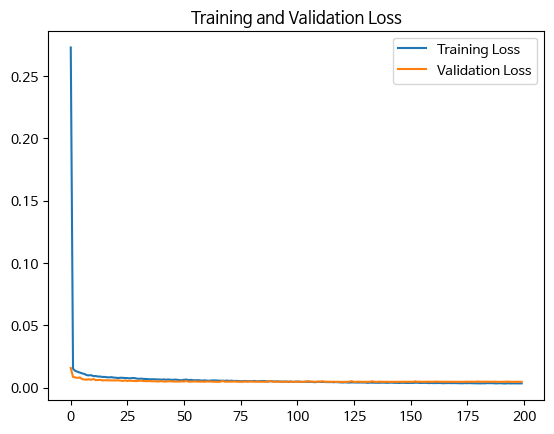

In [ ]:
# 학습 과정 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**시계열 모델**

`MSE(Mean Squared Error) - 'test_loss'`: 예측 값과 실제 값의 차이의 제곱의 평균입니다. 이 값은 모델이 얼마나 잘하는지 또는 못하는지를 대략적으로 나타내며, 값이 낮을 수록 좋은 성능을 의미합니다.

`MAE(Mean Absolute Error) - 'test_mae'`: 예측 값과 실제 값의 차이의 절대값의 평균입니다. 이 값은 오차의 크기를 직관적으로 이해하기 쉬우며, 값이 낮을수록 성능이 좋다는 것을 의미합니다.

`RMSE(Root Mean Squared Error) - 'test_rmse'`: MSE의 제곱근입니다. RMSE는 큰 오차에 더 많은 가중치를 주기 때문에, 모델이 큰 오차를 만들어내는 경향이 있는지를 평가할 때 유용합니다. RMSE 값도 낮을수록 모델의 성능이 좋습니다.


In [ ]:
# 모델 평가
test_loss, test_mae, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}')

15/15 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0575
Test Loss: 0.003311467356979847, Test MAE: 0.0285665150731802, Test RMSE: 0.05754534900188446


In [ ]:
# 모델 예측
predictions = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


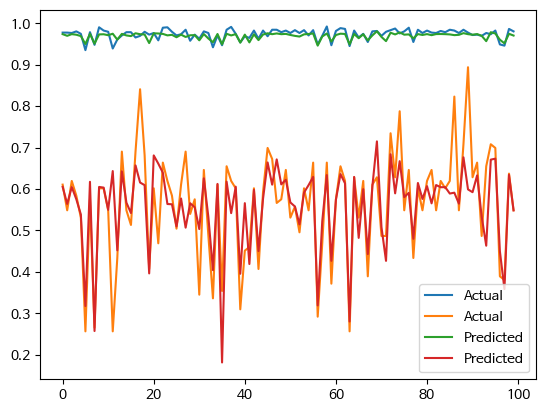

In [ ]:
# 예측 결과와 실제 값 비교
plt.plot(y_test[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.show()